In [1]:
import jax.numpy as jnp
from jax import jit, grad, vmap
import matplotlib.pyplot as plt
import numpy as np
from jax import random
from jax import jit, jacfwd, lax, jacrev, hessian

key = random.PRNGKey(0)
print(f"{key = }")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


key = Array([0, 0], dtype=uint32)


In [2]:
def reference_function1(t):
    """Trajectory to track"""
    return 3.0

def reference_function2(t):
    """Trajectory to track"""
    return np.sin(t)

def reference_function3(x10, t):
    """Trajectory to track"""
    return x10 + t

In [3]:
reffunc = reference_function2

In [4]:
# Simulation parameters
T = 10.0  # Time Horizon of simulation
SIM_STEP = 0.1  # Time step of simulation
T_lookahead = 0.8  # Time horizon for Control
INTEGRATION_STEP = 0.1
C = jnp.array([[1, 0]])

x10 = 0.0  # initial state
x20 = 0.0  # initial state
x30 = 0.0  # initial state
state0 = jnp.array([x10, x20])
u0 = 0.1
input0 = jnp.array([u0])

# Initial conditions
states = np.zeros((int(T/SIM_STEP), len(state0)))
inputs = np.zeros((int(T/SIM_STEP), len(input0)))
refs = np.zeros((int(T/SIM_STEP), len(input0)))
i = 0
states[i] = state0  # Initial state
inputs[i] = u0  # Initial input
refs[i] = reffunc(0.0+T_lookahead)  # Initial reference



In [5]:
from jax import debug

# @jit
def dynamics(state, input):
    """Compute the state derivative."""
    x1, x2 = state
    u = input
    # # print(f"{x1 = }, {x2 = }, {x3 = }, {u = }")
    # x1d = jnp.sin(x2) + (x2 + 1) * x3
    # x2d = x1**5 + x3
    # x3d = x1**2 + u
    # x1d = x2
    # x2d = x3
    # x3d = u

    x1d = x2**3 + u
    x2d = u
        
    # Use jax.debug.print to force JAX to print during execution
    # debug.print("x1d = {x1d}, x2d = {x2d}, x3d = {x3d}", x1d=x1d, x2d=x2d, x3d=x3d)

    return jnp.array([x1d, x2d])


# @jit
def get_next_state(state, u, timestep, key):
    """Update state using the dynamics."""
    key, subkey = random.split(key)
    dxdt = dynamics(state, u)
    x_next = state + dxdt * timestep + 0.001 * random.normal(subkey, (len(state),))
    return x_next, key


In [6]:
next_state, key = get_next_state(state0, u0, SIM_STEP, key)
print(f"{next_state = }")
print(f"{key = }")

next_state = Array([0.01019308, 0.00947322], dtype=float32)
key = Array([4146024105,  967050713], dtype=uint32)


In [7]:
def fwd_euler(state, input, integration_step, integrations_int):
    """Forward Euler integration."""
    def for_function(i, current_state):
        return current_state + dynamics(current_state, input) * integration_step

    pred_state = lax.fori_loop(0, integrations_int, for_function, state)
    return pred_state

def predict_state(state, u, T_lookahead, integration_step):
    """Predict the next state."""
    integrations_int = int(T_lookahead / integration_step)
    pred_state = fwd_euler(state, u, integration_step, integrations_int)
    return pred_state

def predict_output(state, u, T_lookahead, integration_step, C):
    """Predict the output."""
    pred_state = predict_state(state, u, T_lookahead, integration_step)
    return C @ pred_state


In [8]:
aa = predict_state(state0, u0, T_lookahead, 0.1)
bb = fwd_euler(state0, u0, 0.1, 8)
cc = predict_output(state0, u0, T_lookahead, 0.1, C)
print(f"{aa = }")
print(f"{bb = }")
print(f"{cc = }")

aa = Array([0.0800784 , 0.08000001], dtype=float32)
bb = Array([0.0800784 , 0.08000001], dtype=float32)
cc = Array([0.0800784], dtype=float32)


In [9]:
# get jacobian of predition with respect to input
# @jit
def get_jac_pred_u(state, last_input, T_lookahead, integration_step, C):
    return jacfwd(predict_output, 1)(state, last_input, T_lookahead, integration_step, C)

# @jit
def NR_tracker(currstate, currinput, ref, T_lookahead, integration_step, C, sim_step):
    """Newton-Raphson method to track the reference trajectory."""
    alpha = 20
    pred = predict_output(currstate, currinput, T_lookahead, integration_step, C)
    dgdu = get_jac_pred_u(currstate, currinput, T_lookahead, integration_step, C)
    dgdu_inv = 1/dgdu if dgdu.shape[0] == 1 else jnp.linalg.inv(dgdu)

    print(f"{pred = }")
    print(f"{ref = }")
    error = (ref - pred)
    print(f"{error = }")

    print(f"{dgdu = }")
    print(f"{dgdu_inv = }")
    NR = dgdu_inv @ error
    print(f"{NR = }")
    udot = alpha * NR
    print(f"{udot = }")

    change_u = udot * sim_step
    print(f"{change_u = }")

    print(f"{currinput = }")
    new_u = currinput + change_u
    print(f"{new_u = }")
    return new_u


In [10]:
dgdu = get_jac_pred_u(state0, u0, 1.2, 0.01, C)
print(f"{dgdu = }")


dgdu = Array([1.2152941], dtype=float32)


In [11]:
#@jit
def error_func(state, u, T_lookahead, integration_step, C, ref):
    """Compute the error."""
    pred = predict_output(state, u, T_lookahead, integration_step, C)
    return (ref - pred)**2

#@jit
#get error func derivative wrt input
def get_grad_error_u(state, u, T_lookahead, integration_step, C, ref):
    return jacfwd(error_func, 1)(state, u, T_lookahead, integration_step, C, ref)

#@jit
#get hessian of error func wrt input
def get_hess_error_u(state, u, T_lookahead, integration_step, C, ref):
    return jacfwd(get_grad_error_u, 1)(state, u, T_lookahead, integration_step, C, ref)


In [12]:
dgdu = get_grad_error_u(state0, u0, T_lookahead, 0.1, C, 3.0)
print(f"{dgdu = }")
hess = get_hess_error_u(state0, u0, T_lookahead, 0.1, C, 3.0)
print(f"{hess = }")

dgdu = Array([-4.68561], dtype=float32)
hess = Array([1.0128311], dtype=float32)


In [13]:
def NR_tracker_2(currstate, currinput, ref, T_lookahead, integration_step, C, sim_step):
    """Newton-Raphson method to track the reference trajectory."""
    alpha = 20
    pred = predict_output(currstate, currinput, T_lookahead, integration_step, C)
    error = error_func(currstate, currinput, T_lookahead, integration_step, C, ref)
    print(f"{pred = }")
    print(f"{ref = }")
    print(f"{error = }")

    dgdu = get_grad_error_u(currstate, currinput, T_lookahead, integration_step, C, ref)
    hess = get_hess_error_u(currstate, currinput, T_lookahead, integration_step, C, ref)
    d2gdu2_inv = jnp.linalg.inv(hess) if hess.shape[0] > 1 else 1/hess
    print(f"{dgdu = }")
    print(f"{hess = }")
    print(f"{d2gdu2_inv = }")


    

    scaling = d2gdu2_inv @ dgdu
    scaling = scaling.reshape(1,)
    print(f"{scaling = }")
    NR = scaling
    udot = -alpha * NR
    print(f"{udot = }")

    change_u = udot * sim_step
    print(f"{change_u = }")

    print(f"{currinput = }")
    new_u = currinput + change_u
    print(f"{new_u = }")
    return new_u

In [14]:
NR_tracker(state0, u0, 0.08, T_lookahead, 0.1, C, SIM_STEP)

pred = Array([0.0800784], dtype=float32)
ref = 0.08
error = Array([-7.840246e-05], dtype=float32)
dgdu = Array([0.80235195], dtype=float32)
dgdu_inv = Array([1.2463359], dtype=float32)
NR = Array(-9.77158e-05, dtype=float32)
udot = Array(-0.00195432, dtype=float32)
change_u = Array(-0.00019543, dtype=float32)
currinput = 0.1
new_u = Array(0.09980457, dtype=float32)


Array(0.09980457, dtype=float32)

In [15]:
NR_tracker_2(state0, u0, 0.08, T_lookahead, 0.1, C, SIM_STEP)

pred = Array([0.0800784], dtype=float32)
ref = 0.08
error = Array([6.1469456e-09], dtype=float32)
dgdu = Array([0.00012581], dtype=float32)
hess = Array([1.2875447], dtype=float32)
d2gdu2_inv = Array([0.77667207], dtype=float32)
scaling = Array([9.771523e-05], dtype=float32)
udot = Array([-0.0019543], dtype=float32)
change_u = Array([-0.00019543], dtype=float32)
currinput = 0.1
new_u = Array([0.09980457], dtype=float32)


Array([0.09980457], dtype=float32)

In [16]:
# Run simulation
i= 0
for t in jnp.arange(SIM_STEP, T, SIM_STEP):
    print(f"Iteration #{i} at {t} seconds")
    i+=1

    currstate = states[i-1]
    currinput = inputs[i-1].item()
    print(f"{currstate= }, {currinput= }")
    next_state, key = get_next_state(currstate, currinput, SIM_STEP, key)

    ref = reffunc((t+T_lookahead))
    print(f"{ref = }")

    new_input = NR_tracker(currstate, currinput, ref, T_lookahead, INTEGRATION_STEP, C, SIM_STEP).item()
    # new_input = NR_tracker_2(currstate, currinput, ref, T_lookahead, INTEGRATION_STEP, C, SIM_STEP).item()
    print(f"{new_input = }")

    states[i] = next_state
    inputs[i] = new_input
    refs[i] = ref
    print(f"\n")


    

Iteration #0 at 0.10000000149011612 seconds
currstate= array([0., 0.]), currinput= 0.1
ref = 0.7833269
pred = Array([0.0800784], dtype=float32)
ref = 0.7833269
error = Array([0.7032485], dtype=float32)
dgdu = Array([0.80235195], dtype=float32)
dgdu_inv = Array([1.2463359], dtype=float32)
NR = Array(0.87648386, dtype=float32)
udot = Array(17.529676, dtype=float32)
change_u = Array(1.7529677, dtype=float32)
currinput = 0.1
new_u = Array(1.8529677, dtype=float32)
new_input = 1.8529677391052246


Iteration #1 at 0.20000000298023224 seconds
currstate= array([0.01000871, 0.00995112]), currinput= 1.8529677391052246
ref = 0.841471
pred = Array([2.0056803], dtype=float32)
ref = 0.841471
error = Array([-1.1642094], dtype=float32)
dgdu = Array([1.6231288], dtype=float32)
dgdu_inv = Array([0.61609405], dtype=float32)
NR = Array(-0.71726245, dtype=float32)
udot = Array(-14.345249, dtype=float32)
change_u = Array(-1.4345249, dtype=float32)
currinput = 1.8529677391052246
new_u = Array(0.41844285, dty

In [17]:
ts = np.arange(0, T, SIM_STEP)
x1s = states[:,0]
x2s = states[:,1]
# x3s = states[:,2]

r1s = refs[:,0]
# r2s = refs[:,1]
# r3s = refs[:,2]

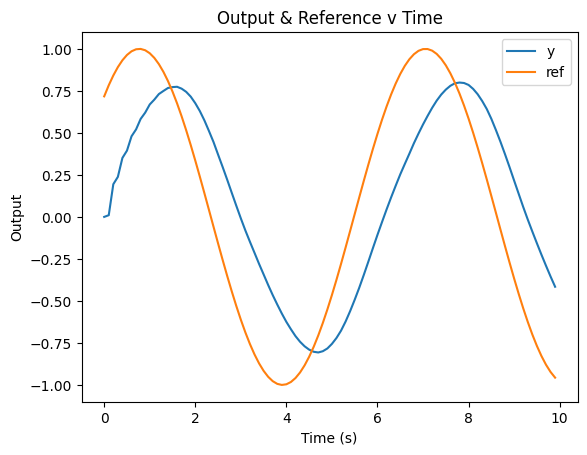

In [18]:
#make figure 1

plt.figure(1)
plt.plot(ts, x1s, label="y")
plt.plot(ts, r1s, label="ref")
plt.title("Output & Reference v Time")
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.legend()

In [19]:
refs

array([[ 0.71735609],
       [ 0.78332692],
       [ 0.84147102],
       [ 0.89120734],
       [ 0.93203908],
       [ 0.96355814],
       [ 0.98544973],
       [ 0.997495  ],
       [ 0.99957359],
       [ 0.99166483],
       [ 0.97384763],
       [ 0.94630009],
       [ 0.90929741],
       [ 0.86320931],
       [ 0.80849636],
       [ 0.74570525],
       [ 0.67546314],
       [ 0.59847218],
       [ 0.51550126],
       [ 0.42737985],
       [ 0.33498821],
       [ 0.23924947],
       [ 0.14112   ],
       [ 0.04158076],
       [-0.05837395],
       [-0.15774564],
       [-0.25554097],
       [-0.35078323],
       [-0.44252035],
       [-0.52983594],
       [-0.61185783],
       [-0.68776602],
       [-0.7568025 ],
       [-0.81827706],
       [-0.87157565],
       [-0.91616601],
       [-0.9516021 ],
       [-0.97753012],
       [-0.99369097],
       [-0.99992323],
       [-0.99616462],
       [-0.98245257],
       [-0.95892429],
       [-0.92581457],
       [-0.8834545 ],
       [-0

In [20]:
np.sin(.1)

0.09983341664682815

In [21]:
reference_function(0, [0])

NameError: name 'reference_function' is not defined

In [ ]:
reference_function(0, [0])

In [ ]:
len([0])